### Import libs and Read Source file

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import traceback, os
from pyspark.sql.window import Window
from pyspark.sql.types import *

In [2]:
events_df = spark.read.format("csv")\
            .option("header",True)\
            .load("C:\Sr_DE_Takehome\BDO_DataEngineering_Tasks\Data_Engineer_Take_home_dataset.csv")

In [3]:
# Tried below config and infer schema options.But losing the original data. Bcoz currently there's no daylight saving.
# dataset is having timestamp with UTC - 4:00. After applying below timeZone configs, I get UTC - 5:00. mismatch/Loss of 1 hr
#spark.conf.set("spark.sql.session.timeZone","EST")
#spark.conf.set("spark.sql.session.timeZone","UTC")

# Adding this config to use old datetime parser
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

# Solutions

### ---TASK 1---
### Task 1.1 - Compute the average time on flyer per user.

### Assumptions for Task 1.1

#### Assuming "flyer_open" and "item_open" events as the only 2 events when user interact with flyers and spent time on.

#### Data Cleaning and filtering - Select records where event in (flyer_open and item_open) and flyer_id not in ("%3Cnull%3G","","null")

In [4]:
filtered_events_df = events_df.filter(\
                        (col("event").isin("flyer_open","item_open")) &
                        (~col("flyer_id").isin("%3Cnull%3G","","null")))

In [5]:
# Adding new column "converted_timestamp"
filtered_events_df = filtered_events_df\
        .withColumn("offset",expr('right(timestamp,6)'))\
        .withColumn("converted_timestamp",to_timestamp(substring('timestamp',0,19),"yyyy-MM-dd'T'HH:mm:ss"))

In [6]:
#filtered_events_df.createOrReplaceTempView("filtered_events_df")

In [7]:
# filtered_events_w_diff_df = spark.sql("""
#     SELECT *,
#         CASE WHEN converted_timestamp - lag(converted_timestamp) OVER (PARTITION BY user_id ORDER BY converted_timestamp)
#                 <= interval 20 minutes
#             THEN converted_timestamp - lag(converted_timestamp) OVER (PARTITION BY user_id ORDER BY converted_timestamp)
#         END As curr_prev_diff_ts
#     FROM filtered_events_df
#         """)


# Creating partition to calculate the elapsed time between 2 events
winspec = Window.partitionBy("user_id").orderBy("converted_timestamp")
filtered_events_w_diff_df = filtered_events_df\
                .withColumn("curr_prev_diff_ts",col('converted_timestamp')-lag(col('converted_timestamp')).over(winspec))\
                .withColumn("curr_prev_diff_ts",col("curr_prev_diff_ts").cast(StringType()))

In [8]:
# Following below extraction, transformation and conversion method as there was a dataloss while setting the timezone.
# These steps would have eliminated if the timestamp column data would have matched with current UTC/EST timezone.
events_df_with_formatted_time = filtered_events_w_diff_df.withColumn("formatted_time",regexp_replace(col("curr_prev_diff_ts")," hours ",":"))\
                    .withColumn("formatted_time",regexp_replace(col("formatted_time")," minutes ",":"))\
                    .withColumn("formatted_time",regexp_replace(col("formatted_time")," seconds",""))\
                    .withColumn("splitted_time",split(col("formatted_time"),":"))\
                    .withColumn("time_to_secs",when(size(col("splitted_time"))==3,
                                                    col("splitted_time").getItem(0)*3600+
                                                    col("splitted_time").getItem(1)*60+
                                                    col("splitted_time").getItem(2))\
                                               .when(size(col("splitted_time"))==2,
                                                     col("splitted_time").getItem(0)*60+
                                                     col("splitted_time").getItem(1))
                                               .otherwise(col("formatted_time")))\
                    .withColumn("time_to_secs",col("time_to_secs").cast(IntegerType()))\
                    .drop(*["formatted_time","splitted_time","timestamp"])

### I am assuming that if the difference between 2 events is less than 2 hrs then user is active and spent time on flyers.
### In other words, I am removing the outliers which will un-necessarily skew the avg time.

In [9]:
final_events_df = events_df_with_formatted_time.filter(col("time_to_secs")<7600)
# final_events_df = events_df_with_formatted_time

In [10]:
# Calculating the avg time
final_events_df = final_events_df.groupBy("user_id",date_format(col("converted_timestamp"),"dd-MM-yyyy").alias("date"))\
    .agg(avg("time_to_secs").cast(DecimalType(18,2)).alias("avg_time_spent_in_secs"))

### In the below output we can see that user "4e0521677630b9df7d69717098024419179910e1fff66d24a1affbc084b0c91f" has spent 71.27 secs on an average on 1st Oct 2018 on flyers

In [11]:
final_events_df.show(10,False)

+----------------------------------------------------------------+----------+----------------------+
|user_id                                                         |date      |avg_time_spent_in_secs|
+----------------------------------------------------------------+----------+----------------------+
|4e0521677630b9df7d69717098024419179910e1fff66d24a1affbc084b0c91f|01-10-2018|71.27                 |
|74130f3f5de109961e12f22e8c802dc8fdafda2a045b60556cf2e604bfa98e62|01-10-2018|1560.86               |
|7b8f402162b5d8012c075cade7c331dc7ceccafc93de5a03bc1c272ef55477e6|01-10-2018|267.00                |
|a043a79b8262033eade50cd80b31b9c4883a3a77294634d2b91267e90c886c2a|01-10-2018|1525.50               |
|c104b2e862e69bbd850a7ddfb49e6d6455be36f0bc74774f4057def99ef25715|01-10-2018|497.00                |
|e1c3694b2b58532d7fd48283fdc8d6b6fd791397452fc45f9268af48015babd8|01-10-2018|78.11                 |
|0655466fd378fe385057e604caa841586385e597ffc4476c55f8a5ab1420ee23|01-10-2018|541.83        

### Task 1.2 - Next, generate an output that will back a Business Intelligence (Bl) report that will be shared with our merchant partners.
### This can be use to understand what kind of flyers user spent time on and accordingly we can provide recommendations

In [12]:
events_df_with_formatted_time.filter(col("time_to_secs")<7600).show(5)

+--------------------+----------+--------+-----------+------+-------------------+-----------------+------------+
|             user_id|     event|flyer_id|merchant_id|offset|converted_timestamp|curr_prev_diff_ts|time_to_secs|
+--------------------+----------+--------+-----------+------+-------------------+-----------------+------------+
|4e0521677630b9df7...|flyer_open| 1998362|       2432|-04:00|2018-10-01 11:33:38|       38 seconds|          38|
|4e0521677630b9df7...|flyer_open| 2016316|       2268|-04:00|2018-10-01 11:34:13|       35 seconds|          35|
|4e0521677630b9df7...|flyer_open| 2009401|       2362|-04:00|2018-10-01 11:34:16|        3 seconds|           3|
|4e0521677630b9df7...|flyer_open| 2009693|       2066|-04:00|2018-10-01 11:34:48|       32 seconds|          32|
|4e0521677630b9df7...|flyer_open| 2016439|       2609|-04:00|2018-10-01 11:35:26|       38 seconds|          38|
+--------------------+----------+--------+-----------+------+-------------------+---------------

### As we would be sharinig the data with merchants. One of the metric can be...
### How much time user spent on which flyer by merchants?

In [13]:
events_df_with_formatted_time.filter(col("time_to_secs")<7600).groupBy("merchant_id","flyer_id","user_id",date_format(col("converted_timestamp"),"dd-MM-yyyy").alias("date"))\
    .agg(sum("time_to_secs").cast(DecimalType(18,2)).alias("total_time_spent_in_secs"),\
     avg("time_to_secs").cast(DecimalType(18,2)).alias("avg_time_spent_in_secs")).show(5)

+-----------+--------+--------------------+----------+------------------------+----------------------+
|merchant_id|flyer_id|             user_id|      date|total_time_spent_in_secs|avg_time_spent_in_secs|
+-----------+--------+--------------------+----------+------------------------+----------------------+
|       2432| 1998362|4e0521677630b9df7...|01-10-2018|                   38.00|                 38.00|
|       2268| 2016316|4e0521677630b9df7...|01-10-2018|                   35.00|                 35.00|
|       2362| 2009401|4e0521677630b9df7...|01-10-2018|                    3.00|                  3.00|
|       2066| 2009693|4e0521677630b9df7...|01-10-2018|                  196.00|                 98.00|
|       2609| 2016439|4e0521677630b9df7...|01-10-2018|                   38.00|                 38.00|
+-----------+--------+--------------------+----------+------------------------+----------------------+
only showing top 5 rows



### In the above output we can see that, for merchant "2066", user "4e0521677630b9df7d69717098024419179910e1fff66d24a1affbc084b0c91f" has spent total 196 secs and avg 98 secs on flyer "2009693", on 1st oct 2018

### Task 1.3 - Explain how your algorithm scales for:
####   - 1 Million Events (~10 MB of data)
####   - 1 Trillion Events (~10 TB of data)
#### --------------------------------------------------------------------------------

### Explainiation - As I am using PySpark. Scalability depends on the size of cluster and the resources allocated to the jobs. Need to understand the size of the data that we might process and accordingly we can assign resources.

### ---TASK 2---

### Task 2.1<br>Design a workflow to move the user behaviour event data from the application to a backend and provide insights into the data pipelines that you foresee

### Keeping all the requirements in mind, below architecture would be suitable.

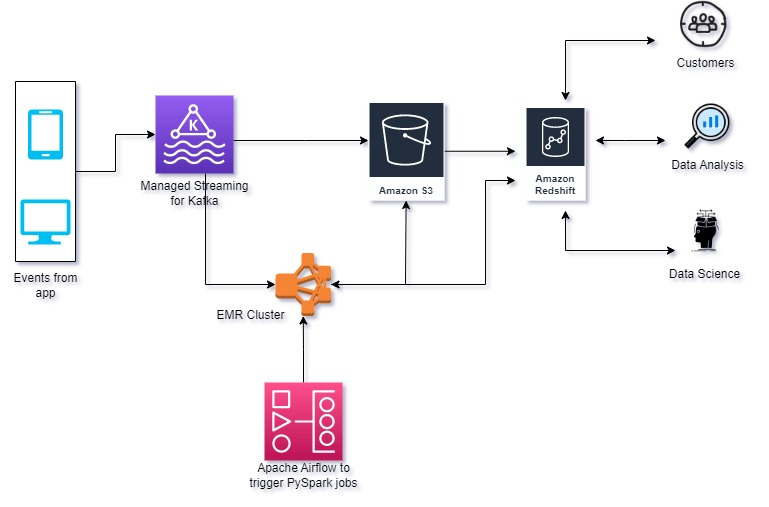

### Task 2.2<br>Explain how the workflow would provide the data to the batch process in Part 1 Algorithm.

### Explaination - Eventually the data will be stored in datalake(i.e S3). We can directly store the raw data via Kafka to S3 OR via PySpark.<br>- We can use scheduling tools(like Apache Airflow/Apache Nifi) to trigger PySpark jobs which would run on EMR cluster. <br>- These jobs will read data from S3 and write the cleaned and tranformed data back to S3 Or maybe directly to Data warehouse(Redshift) if needed.

### Task 2.3<br>Explain any adaptations that your work from Part 1 - Algorithm would need to work as a streaming process.

### Explaination - Again an added advantage of using PySpark. For this, we can use Kafka and PySpark integration for reading streams of data.
### Here are the high level steps to process streams of data. <br>- We can read data from Kafka servers by subscribing to particular topic. <br>- Create dataframe.<br>- Use the code in Part 1 for transformation.<br>- keep writing the data datalake(S3) or upserting straight to Redshift if needed.

### Task 2.4<br>Highlight any important design decisions you make, and describe briefly why you made those decisions.

### Explaination<br>- We can mimic the entire setup on premise as well. But maintaining on prem architecture would give us a headache. Better to use any cloud platform for this.<br>- Keeping all the components in same VPC and Zone/Region would definetly reduce the latency.<br>- The cloud services are easy to setup, configurable and are autoscalable with few configurations.<br>- Processing of data would be fault taulerant as Spark maintains the lineage graph, and RDDs can be re-build using the graph, so it can retrive lost partitions in terms of failure.